In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-29 22:57:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-29 22:57:10 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Module Import

In [ ]:
import datetime as dt
import os
import pathlib

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import matplotlib.image as mpimg
import helper_functions as hf


from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2.8.2


### Regression NN Model

In [ ]:
def plot_actual_prediction(x_train,y_train,x_test,y_test,y_pred):
  """
  plot the scatter plot for actual and predicted value
  """
  plt.figure(figsize=(12,9))
  plt.scatter(x_train,y_train,c = "blue",label="train")
  plt.scatter(x_test,y_test,c="green",label="test")
  plt.scatter(X_test,y_pred,c="red",label="prediction")
  plt.legend()

def mae(y_true,y_pred):
  """
  calculate mae
  """
  return tf.metrics.mean_absolute_error(y_true,y_pred)
  
def mse(y_true,y_pred):
  return tf.metrics.mean_squared_error(y_true,y_pred)

### Classification NN Model

In [ ]:
def sigmoid(z):
  return 1 / (1+tf.exp(-z))

def relu_func(z):
  return tf.maximum(0,z)

def linear_func(z):
  return z

def softmax(z,*args):
  total_probs = sum([tf.exp(z_) for z_ in args])
  return z*1.0 /total_probs

def plot_decision_boundary(model,X,y,activation_on_output_layer=True):

  X_min, X_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
  y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1

  # the X axxis and Y axix data point on the plot
  XX, yy = np.meshgrid(np.linspace(X_min,X_max,100),
                        np.linspace(y_min,y_max,100)) 

  X_in = np.c_[XX.ravel(),yy.ravel()]  # prepare the simulated datasets
  y_pred = model.predict(X_in)
  if not activation_on_output_layer:
    y_pred = 1 / (1+tf.exp(-y_pred))
  

  # becauase want to class ID like the index of maximum to make it as the color in the plot, 
  # like use differentt ID represent different color represent different category
  if y_pred.shape[1] > 1:
    print("doing multiclass classifications.")
    y_pred_class = np.argmax(y_pred,axis=1).reshape(XX.shape)
    
  else:
    print("doing binary class classification.")
    y_pred_class = np.round(y_pred).reshape(XX.shape)

  plt.contourf(XX,yy, y_pred_class,cmap=plt.cm.RdYlBu,alpha=0.5)
  plt.scatter(X[:,0],X[:,1], s=40, c = y,cmap=plt.cm.RdYlBu)
  plt.xlim(XX.min(),XX.max())
  plt.ylim(yy.min(),yy.max())

In [ ]:
def plot_confusion_matrix(y_true,y_pred,classes=None,figsize=(20,16)):
  fig, ax = plt.subplots(figsize=figsize)

  # only calculate the TPR and FPR
  cm = confusion_matrix(y_true,y_pred)
  c_norm = cm / cm.sum(axis=1)[:,np.newaxis]
  cmt = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cmt)

  # format the ax and make it prettier
  ax.xaxis.set_ticks_position("bottom")
  ax.xaxis.tick_bottom()
  ax.title.set_size(20)
  ax.xaxis.label.set_size(10)
  ax.yaxis.label.set_size(10)

  labels = classes if classes else np.arange(cm.shape[0])

  ax.set(
      title = "Confusion Matrix",
      xlabel = "Predicted Label",
      ylabel = "Actual Label",
      xticks = np.arange(cm.shape[0]),
      yticks = np.arange(cm.shape[0]),
      xticklabels = labels,
      yticklabels = labels
  )

  threshold = (cm.max()+cm.min()) / 2

  # the text cords is same as the screen, the y-axis is going down
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[0])):
    plt.text(j,i,f"{cm[i,j]} ({c_norm[i,j]*100:.1f}%)",
            size=10,
            horizontalalignment="center",
            color = "white" if cm[i,j] > threshold else "black")


In [ ]:
def plot_random_image(model,images,actual_labels,classes):
  import random

  # pick up random one image.
  i = random.randint(0,len(images))
  target_image = images[i]
  y_pred_prob = model.predict(images[i].reshape(1,28,28)) # convert to batch size as 1,x,y
  pred_labels = classes[tf.argmax(y_pred_prob,axis=1)[0]]
  true_labels = classes[actual_labels[i]]

  plt.imshow(images[i],cmap=plt.cm.binary)

  color = "red" if pred_labels != true_labels else "green"

  # only show the maximum prob that will be used to categorized the sample into the predicted label
  plt.xlabel("Pred:{pred_labels}, {pred_prob:2.0f}% | Actual:{true_labels}".format(pred_labels = pred_labels,
                                                                                 pred_prob = 100*tf.math.reduce_max(y_pred_prob),
                                                                                 true_labels = true_labels),
             color=color)


In [ ]:
def plot_random_images(model,images,actual_labels,classes,n_samples_vec=1,certain_class=None):
  """
  Plot multiple images by randonmly picking up the image from data
  and also can plot the pic with a specific class
  
  """
  
  import random

  matrix_samples = n_samples_vec**2

  if certain_class and certain_class not in classes:
    raise Exception("Please give a valid class define in the classes params")

  if certain_class:
    class_names_dict = {v:k for k,v in enumerate(classes)}
    class_id = class_names_dict.get(certain_class)
    filter_tensor = actual_labels == class_id
    images = images[filter_tensor]
    actual_labels = actual_labels[filter_tensor]

  plt.figure(figsize=(20,20))
  # pick up random one image.
  for loc in range(matrix_samples):
    plt.subplot(n_samples_vec,n_samples_vec,loc+1)
    
    i = random.randint(0,len(images))
    target_image = images[i]
    y_pred_prob = softmax(model.predict(target_image.reshape(1,28,28))) # convert to batch size as 1,x,y
    pred_labels = classes[tf.argmax(y_pred_prob,axis=1)[0]]
    true_labels = classes[actual_labels[i]]
 

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(target_image,cmap=plt.cm.binary)
    
   
    color = "red" if pred_labels != true_labels else "green"

    # only show the maximum prob that will be used to categorized the sample into the predicted label
    plt.xlabel("Pred:{pred_labels}, {pred_prob:2.0f}% | Actual:{true_labels}".format(pred_labels = pred_labels,
                                                                                  pred_prob = 100*tf.math.reduce_max(y_pred_prob),
                                                                                  true_labels = true_labels),
              color=color)
  plt.show()


### Convolution NN Model 

In [ ]:
# random pickup a image and check
import pathlib
import random

def view_random_image(target_dir,target_class):
  target_folder = target_dir + "/" + target_class
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)

  # convert the image to numerical data
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape:{img.shape}")

  return img

In [ ]:
def plot_loss_curve(history):
  loss = history.history["loss"] # train loss
  val_loss = history.history["val_loss"] # val loss
  accuracy = history.history["accuracy"] # train accuracy
  val_accuracy = history.history["val_accuracy"] # test accuracy

  epochs = range(len(loss))
  epochs = list(map(lambda x:int(x+1),epochs))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.xticks(epochs)
  plt.legend()
  plt.show()

  plt.plot(epochs,accuracy,label="training_acc")
  plt.plot(epochs,val_accuracy,label="validation_acc")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.xticks(epochs)
  plt.legend()

In [ ]:
# processing the unknown dataset so that it can be fit to the models' acceptable input format
def load_and_prep_image(filename,img_shape=224):
  """
  reads image and turn it into the tensor and reshape it
  """
  img = tf.io.read_file(filename)

  img = tf.image.decode_image(img)

  # why don't we define color channel because when decode the image or read file using tf, the channel has been read.
  img = tf.image.resize(img,[img_shape,img_shape])

  img = img * 1./255

  return img

def pred_and_plot(model,filename,class_names):
  img = load_and_prep_image(filename,img_shape=224)

  pred = model.predict(tf.expand_dims(img,axis=0))

  ind = int(np.round(pred))

  pred_class = class_names[ind]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}, prob.:{pred.ravel()[0]*100:.2f}%")

### Transfer Learning - Feature Extraction

In [ ]:
### 1. Set up Tracking experiments
def create_tensorboard_callback(dir_name,experiment_name):
  dir = dir_name+"/"+experiment_name+"/" + dt.datetime.now().strftime("%Y%m%d_%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = dir)
  print(f"Generate Folder {dir} for tracking exp")
  return tensorboard_callback


def create_model(model_url, num_classes=10):
  global IMG_SIZE
  """
  take a tensorflow hub model to create keras Sequential Model
  Args:
    model_url (str): model url from tensorflow hub
    num_classes: the number of target classes default is 10
  Returns:
    Return hub model with num_classes neurons in the output layer
  """
  # like the combine all layers from the hub model into one composite layer
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url,
                   trainable=False, # it meas this layer won't have any trainable params 
                  # if switch to True, then might need to more time to train this pre-trained model
                   name="feature_extraction_layer",
                   input_shape = IMG_SIZE+(3,)),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax',name="output_layer")
  ])

  return model


### Transfer Learning - Fine Tuning

In [ ]:
def predict_plot_image(model,class_names):
  import random
  for images,labels in test_data.take(1):
    imgs = images
    labls = labels

  class_names = test_data.class_names
  choice = random.choice(range(len(imgs)))
  random_image = images[choice]/255.
  actual_label = class_names[np.argmax(labls[choice])]
  ind_argmax = tf.argmax(model_0.predict(tf.expand_dims(random_image,axis=0)),axis=1)
  predict_label = class_names[tf.squeeze(ind_argmax)]
  color = "red" if actual_label != predict_label else "green"

  plt.figure(figsize=(12,9))
  plt.imshow(random_image)
  plt.title(f"Predicted Label {predict_label}; Actual Label: {actual_label}",c=color)
  plt.axis(False)

# fine tuning
def load_and_prep_image(filename, img_shape=224, scale=True):

  # convert file to 0-d string tensor
  img = tf.io.read_file(filename)
  # convert the img to tensor
  img = tf.io.decode_image(img,channels = 3)

  # resize to fit the input
  img = tf.image.resize(img,[img_shape,img_shape])

  # rescale if need
  img = img/255. if scale else img

  return img

def autolabel(bar_plot):
    for idx,rect in enumerate(bar_plot):
        val = f1_score_list[idx]
        ax.text(0.01, idx+.25, f"{val*100:.4f}%", color = 'black',)

### Food Vision 101

In [ ]:

# Food Vision 101
def preprocess_image(image,label,img_shape=224):
  img = tf.image.resize(image,size = [img_shape,img_shape])
  return tf.cast(img,tf.float32),label

### NLP

In [ ]:
def pred_timer(model,samples):
  import time
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  return total_time,total_time/len(samples),len(samples)

def calculate_result(y_true,y_pred):
  acc = accuracy_score(y_true=y_true,y_pred=y_pred)

  #precision,recall,f1_score,support
  precision,recall,f1_score,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")

  metrics = {
      "acc":acc * 100,
      "precision": precision,
      "recall": recall,
      "f1_score": f1_score

  }

  return metrics

### Skimlit

In [ ]:
def get_lines(filename):
  lines = []
  with open(filename,"r") as f:
    lines = f.readlines()
  return lines

def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_id = ""
  abstract_line = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line.replace("###","").replace("\n","")
      abstract_line = "" # emtpy the abstract line for each group
    elif line.isspace(): # only contain \n. then record the data in thie gorup with ID
      abstract_line_list = abstract_line.splitlines()

      for line_num, abstract_line in enumerate(abstract_line_list):
        data = {}
        data["line_num"] = line_num
        data["target"] = abstract_line.split("\t")[0]
        data["text"] = abstract_line.split("\t")[1].lower()
        data["total_lines"] = len(abstract_line_list) - 1 # line numbers is count with index 0
        data["ID"] = abstract_id 
        abstract_samples.append(data)
    
    else:
      abstract_line+=line
  
  return abstract_samples

### TimeSeries

In [ ]:
def mean_absolute_scaled_error(y_true,y_pred):
  mae = tf.math.reduce_mean(tf.abs(y_true - y_pred))
  naive_mae = tf.math.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / naive_mae

def plot_timeseries_data(timestamp,values,format=".",start=0,end=None,label=None):
  """
  Plot timeseries data with label

  Parameters:
  --------------
  timestamp: the array of timestamps
  values: the array of values across timestamps
  format: the style of format
  start: start ind of timestamp/value
  end: end ind of timestamp/value
  label: the label for the plot
  """

  plt.plot(timestamp[start:end],values[start:end],format,label=label)
  plt.title("BTC Closing Price Trend within 8 years data")
  plt.xlabel("Day")
  plt.ylabel("Price")
  if label:
    plt.legend()
  plt.grid(True)

def evaluate_preds(y_true,y_pred):
  """
  Description:
  ------------------
  General calculation for metrics. if there is over 1 axis for the actual/prediction label
  reduce to scaler value with average aggregation performed.
  """
  y_true = tf.cast(y_true,dtype=tf.dtypes.float64)
  y_pred = tf.cast(y_pred,dtype=tf.dtypes.float64)

  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = np.sqrt(tf.keras.metrics.mean_squared_error(y_true,y_pred))
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  if y_true.ndim > 1 or len(y_pred.shape) > 1 : # reduce higher axis to scaler
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse).numpy()
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
                          

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse,
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }
  
# can follow the iinput/output pattern from sklearn.model_selection.train_test_split
def make_train_test_split(windows,labels,test_split=0.2):
  split_ind = int((1-test_split)*len(windows))
  train_windows,train_labels = windows[:split_ind],labels[:split_ind]
  test_windows,test_labels = windows[split_ind:],labels[split_ind:]
  return train_windows,train_labels,test_windows,test_labels
## Model checkpooint
import os
def make_model_checkpoint(model_name,save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_name,save_path),
                                                      verbose=0,
                                                      save_best_only=True,)
def make_preds(model,input):
  return tf.squeeze(model.predict(input))
# numpy operation is faster
def create_windows(data,window_size = 7,horizon = 1):
  
  # the index you want to access the data for each window
  windows_step = np.arange(window_size+horizon)

  # index matrix : determine how many windows there
  # perform element-wise operation 
  windows_indexs =  tf.expand_dims(np.arange(len(data)-(window_size+horizon)+1),axis=1) + windows_step


  # access the data
  x = data[windows_indexs]

  windows_data,horizon_label = get_labelled_windows(x,horizon)

  return windows_data,horizon_label
WINDOW_SIZE = 7
HORIZON_SIZE = 1
def get_labelled_windows(data,HORIZON_SIZE = 1):
  """
  Parameters:
  ----------------
  data: should be two dimension matrix

  Returns:
  ----------------
  Return window data for input, horizon data for output
  """
 
  return data[:,:-1*HORIZON_SIZE], data[:,-1*HORIZON_SIZE:]


In [ ]:
def get_ensemble_model(train_data,
                        test_data,
                        horizon = 1,
                        num_iters = 10,
                        epochs=1000,
                        loss_func = ["mae","mse","mape"]):
  """
  30 models in total: 10 * 3 kind of loss function with same model
  """
  ensemble_model = []
  for i in range(num_iters):
    for loss_fn in loss_func:
      print(f"Model-{i} with loss_func:{loss_fn} for epochs {epochs}")
    
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
          tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
          tf.keras.layers.Dense(horizon) # no need activation function, cause right not is to forcast a value not predict a category
      ])

      model.compile(loss=loss_fn,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])
      
      model.fit(train_data,
                epochs = epochs,
                validation_data = test_data,
                verbose=0,
                callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=100,verbose=1),
                           tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=200,restore_best_weights=True)])
      
      ensemble_model.append(model)
  return ensemble_model


def make_ensemble_preds(models,data):
  # 1*15*556 and remove 1
  ensemble_preds = []
  for m in models:
    ensemble_pred = make_preds(m,data)
    ensemble_preds.append(ensemble_pred)
  return tf.constant(tf.squeeze(ensemble_preds))

def get_pred_interval(preds):
  pred_mean = tf.reduce_mean(preds,axis=0) # get mean on each timestamp

  # assume the dist for each timestamp is normal distribution
  # +-1.96 std will include 95% confidence interval 
  pred_std_95 = 1.96*tf.math.reduce_std(preds, axis=0)

  lower,upper = pred_mean - pred_std_95, pred_mean + pred_std_95
  
  return lower,upper

  

# Exam

### 2. Fashion Mnist (5/5) but need to check

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [ ]:
(X_train,y_train),(X_test,y_test) = fashion_mnist.load_data()

In [ ]:
X_train = X_train/255.
X_test = X_test/255.

In [ ]:
y_train.shape

(60000,)

In [ ]:
inputs = tf.keras.layers.Input(shape=(28,28))
x = tf.expand_dims(inputs,axis=-1)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs,outputs)

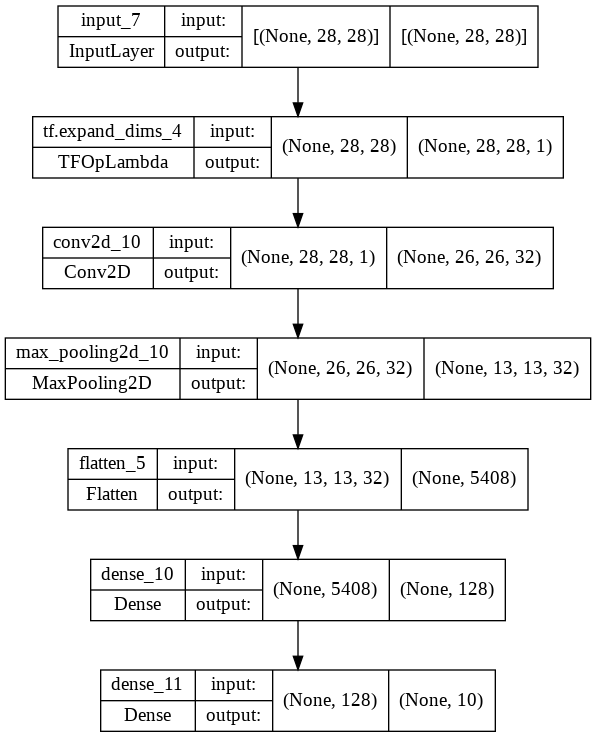

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    validation_data = (X_test,y_test))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3926 - accuracy: 0.8626 - val_loss: 0.3314 - val_accuracy: 0.8781
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2676 - accuracy: 0.9039 - val_loss: 0.2844 - val_accuracy: 0.8940
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2206 - accuracy: 0.9188 - val_loss: 0.2837 - val_accuracy: 0.8964
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1888 - accuracy: 0.9305 - val_loss: 0.2501 - val_accuracy: 0.9047
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1618 - accuracy: 0.9405 - val_loss: 0.2367 - val_accuracy: 0.9172
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1394 - accuracy: 0.9485 - val_loss: 0.2686 - val_accuracy: 0.9095
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1157 - accuracy: 0.9574 - val_loss: 0.2590 - val_accuracy:

In [ ]:
model.save("cnn.h5")

In [ ]:
from google.colab import files
files.download("cnn.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Category 3

In [ ]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')
local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()
urllib.request.urlretrieve(_TEST_URL, 'testdata.zip')
local_zip = 'testdata.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/testdata/')
zip_ref.close()

In [ ]:
!ls -ltr tmp/horse-or-human/

total 40
drwxr-xr-x 2 root root 20480 Jul 29 23:46 horses
drwxr-xr-x 2 root root 20480 Jul 29 23:46 humans


In [ ]:
train_dir = "tmp/horse-or-human/"
test_dir = "tmp/testdata/"

In [ ]:
train_datagen = ImageDataGenerator(
 rescale = 1/255.,
  rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
  shear_range=0.2, # shear the image
  zoom_range=0.2, # zoom into the image
  width_shift_range=0.2, # shift the image width ways
  height_shift_range=0.2, # shift the image height ways
  horizontal_flip=True     
)

validation_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(300, 300),
      batch_size=32,
      class_mode='binary'
   )

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(300,300),
    batch_size=32,
    class_mode="binary",
    shuffle=False)


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(300,300,3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch = len(train_generator),
          validation_data = validation_generator,
          epochs=20)

Epoch 1/20
33/33 [==============================] - 27s 744ms/step - loss: 1.1223 - accuracy: 0.6573 - val_loss: 1.8039 - val_accuracy: 0.5273
Epoch 2/20
33/33 [==============================] - 25s 769ms/step - loss: 0.4180 - accuracy: 0.8179 - val_loss: 2.6790 - val_accuracy: 0.5234
Epoch 3/20
33/33 [==============================] - 25s 769ms/step - loss: 0.2790 - accuracy: 0.8793 - val_loss: 3.8680 - val_accuracy: 0.5352
Epoch 4/20
33/33 [==============================] - 26s 778ms/step - loss: 0.2776 - accuracy: 0.8880 - val_loss: 2.1381 - val_accuracy: 0.5859
Epoch 5/20
 4/33 [==>...........................] - ETA: 21s - loss: 0.1290 - accuracy: 0.9609

KeyboardInterrupt: ignored

In [ ]:
efficientnet = tf.keras.applications.EfficientNetB0(include_top=False)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1 = tf.keras.Sequential([
    
])